# Kernel-Galerkin method with Quadratic Energy

## Imports & Intro

This notebook contains a demo of the kernel-galerkin method in the one-dimensional case, showcasing how the method works and is implemented in this library.

In [1]:
import sys
import os
project_root = os.path.abspath("..")  # If notebooks is one folder above src, change accordingly.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import seaborn as sns
import numpy as np
import pandas as pd
import ipywidgets as widgets
import torch
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from tqdm import tqdm

from src.energy.quadratic import QuadraticEnergy

from src.eigensolver.galerkin.kernel_basis import KernelBasis
from src.eigensolver.galerkin.constant_basis import ConstantBasis
from src.eigensolver.galerkin.kernels.gaussian_kernel import GaussianKernel
from src.eigensolver.galerkin.kernels.polynomial_kernel import PolynomialKernel
from src.eigensolver.galerkin.galerkin_eigensolver import GalerkinSolver

from src.metrics.eigen_evaluator import EigenEvaluator
from src.metrics.pde_evaluator import ExactPDEEvaluator
from src.metrics.reconstruction_evaluator import ReconstructionEvaluator

from src.pdesolver.exact_solver import ExactEigenSolver
from src.pdesolver.fitted_solver import FittedEigenSolver


Consider the operator defined through
$$\mathcal{L}f = -\Delta f + <\nabla E, \nabla f>$$
where $E: \mathbb{R}^d \to \mathbb{R}$ is a given energy function and $<\cdot, \cdot>$ represents the Euclidian inner product. We say that a function $f: \mathbb{R}^d \to \mathbb{R}$  is an eigenfunction of $\mathcal{L}$ if it satisfies $\mathcal{L}f = \lambda f$ for some $\lambda \in \mathbb{R}$. It can be shown that under some conditions on $E$, the above operator has a discrete spectrum, and our goal here is to find the eigenfunctions and associated eigenvalues of $\mathcal{L}$ (note that the constant function is always an eigenfunction with corresponding eigenvalue 0). It can be shown that eigenfunctions with different eigenvalues are orthogonal w.r.t. the inner product defined through
$$<f, g>_\mu = \int f g\ d\mu$$
where $\mu$ is the probability density defined through $\mu(x) \propto \exp(-E(x))$.

In this notebook we will restrict ourselves to the quadratic energy case, where $E(x) = \frac{1}{2}\|x\|^2$. In this case, the eigenfunctions can be computed exactly: each eigenfunction is associated with a tuple $n=(n_1, \ldots, n_d) \in \mathbb{N}^d$, and is given by (up to normalization)
$$\phi_n(x) = H_1(x_1)\ldots H_n(x_n)$$
where $H_i$ denotes the $i$-th Hermite polynomial, which is a polynomial of degree $i$. The corresponding eigenvalue is $n_1 + \ldots + n_d$. Hence we have the following structure of the eigensystem of $\mathcal{L}$:
<center>

| Eigenvalue $\lambda$   | Multiplicity (dimension of eigenspace)| Function type
| :-------:      | :-------: | :------:
| 0       | 1    | Constant function
| 1       | $d$    | Linear functions
| 2       | $d(d+1)/2$ | Quadratic functions
| $\ldots$  | $\ldots$  | $\ldots$ 

</center>

In what follows, we illustrate how we can learn this eigensystem using the Kernel-galerkin method for various dimensions $d$.

## One-dimensional case

### Energy

We use the QuadraticEnergy object to evaluate the energy function and generate samples from $\mu$:

(-3.0, 3.0)

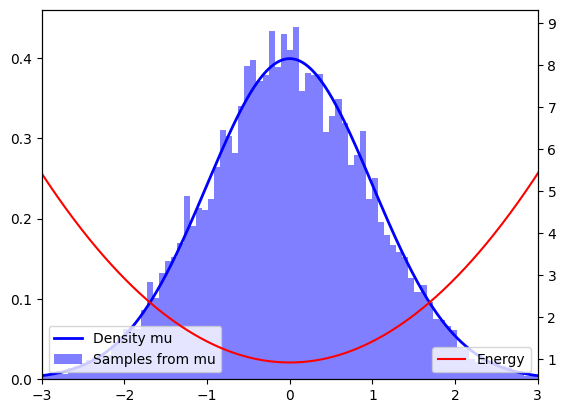

In [3]:
energy = QuadraticEnergy(torch.eye(1))
t = torch.linspace(-4,4,1000).unsqueeze(1)
plt.plot(t, torch.exp(-energy.forward(t)), label = "Density mu", color = 'blue', lw = 2)
plt.hist(energy.exact_sample((10000,)),bins=100,density=True, label = "Samples from mu",color="blue",alpha=.5)
plt.legend(loc = "lower left")
plt.twinx()
plt.plot(t, energy.forward(t), label = "Energy",color='red')
plt.legend(loc = "lower right")
plt.xlim(-3,3)

It also allows us to access the true eigensystem (since $d=1$ each eigenvalue has multiplicity 1):

(-3.0, 3.0)

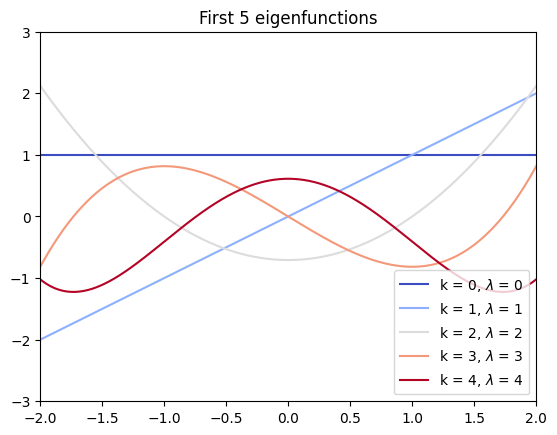

In [3]:
k = 5

exact_eigfuncs = energy.exact_eigfunctions(t,k)
exact_eigvals = energy.exact_eigvals(k)

colormap_name = 'coolwarm'
colormap = plt.get_cmap(colormap_name)

colors = [colormap(i / (k - 1)) for i in range(k)]

for i in range(k):
    plt.plot(t,exact_eigfuncs[:,i], label = f"k = {i}, $\\lambda$ = {exact_eigvals[i]:.0f}", color = colors[i])
plt.legend(loc="lower right")
plt.title(f"First {k} eigenfunctions")
plt.xlim(-2,2)
plt.ylim(-3,3)


### Kernel

The idea of the Galerkin method is to solve the eigenproblem in a finite-dimensional subspace of $L^2(\mu)$, which is defined through the choice of some basis elements $\{b_1,\ldots,b_p\}$. In the kernel method, we sample some points $x_1,\ldots,x_p \sim \mu$ and then set $b_i(x) = k(x,x_i)$ for some fixed kernel $k$. As an example, we can use the RBF kernel defined through
$$k(x,y) = \exp(\|x-y\|^2/(2\sigma^2))$$
for some scale parameter $\sigma$. In our experiments, we will also introduce a constant basis function $b_0(x) = 1$.

Text(0.5, 1.0, '20 kernel basis functions')

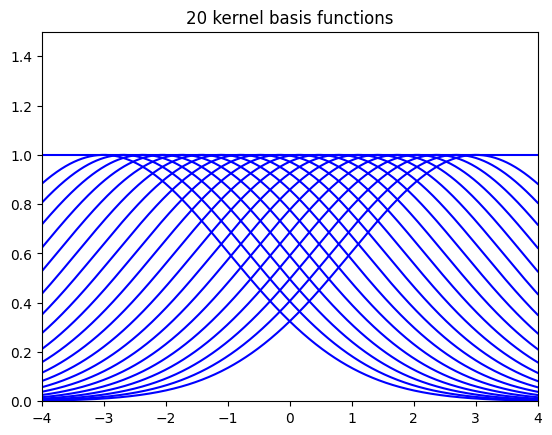

In [4]:
p = 20

kernel_params = {
    'dim': 1,
    'scale': 2.0,
}

kernel = GaussianKernel(kernel_params)

basis_points = torch.linspace(-3,3,p).unsqueeze(1)

kernel_basis = KernelBasis(kernel, basis_points)

# add constant function
basis = ConstantBasis(kernel_basis)

# In practice, we would use samples from mu

plt.plot(t, basis(t),color = 'blue', label = "Basis functions")

plt.xlim(-4,4)
plt.ylim(0,1.5)
plt.title(f'{p} kernel basis functions')

### Galerkin

The idea is now to reduce the infinite-dimensional problem to solving a finite-dimensional eigenvalue problem in the space spanned by the above basis functions. Introduce the operator
$$F: \mathbb{R}^p \to L^2(\mu): \alpha \mapsto \sum_{i=1}^p \alpha_i b_i$$
which maps a set of coordinates to the associated function under this basis. Then (TODO: more explanation) we consider the matrix
$$L = F^* \mathcal{L} F$$
as the "projection" of the operator $\mathcal{L}$ on the finite-dimensional subspace. Here $F^*$ is the adjoint of $F$ w.r.t. the inner product $<\cdot, \cdot>_\mu$. It can be shown that
$$L_{ij} = \mathbb{E}_{x\sim \mu} \left[<\nabla b_i(x), \nabla b_j(x)>\right]$$
Furtermore, we want to impose an orthonormality condition on our eigenfunctions. In $L^2(\mu)$, this is given by $<\phi_i, \phi_j>_\mu = \delta_{ij}$, so for functions with coordinates $\alpha_i, \alpha_j$ this becomes
$$<F\alpha_i, F\alpha_j>_\mu = <\alpha_i, F^*F\alpha_j> = \delta_{ij}$$
We denote $\Phi = F^*F$. This matrix can be computed as 
$$\Phi_{ij} = \mathbb{E}_{x\sim\mu}\left[b_i(x)b_j(x)\right]$$
Thus, we have the following "projection" of the problem on our finite-dimensional space:
$$\text{Find } A \in \mathbb{R}^{k\times p} \text{ such that } ALA^T = \Lambda, \qquad A\Phi A^T = I$$
This is a so-called generalized eigenvalue problem. Given such an $A$, our estimate of the $i$-th eigenfunction is then
$$\hat \phi_i(x) = \sum_{j=1}^p A_{ij} b_j(x).$$

The following code does this operation for our simple case. Note that it is important here to use double precision.

In [5]:
from scipy.linalg import eigh

torch.manual_seed(42)
samples = energy.exact_sample((10000,)).double()

grad_basis = basis.grad(samples)
L = torch.bmm(grad_basis, grad_basis.transpose(1,2)).mean(dim=0)

eval_basis = basis(samples)
Phi = torch.mean(eval_basis[:,:,None]*eval_basis[:,None,:],dim=0)

# Phi and L should both be semi-positive definite, but this can be violated due to numerical errors.

phi_error = torch.linalg.eigvalsh(Phi)[0]
if phi_error >= 0:
    print('Phi is spd.')
else:
    phi_reg = -2*phi_error
    print(f'Phi is not spd, adding regularizer {phi_reg}')
    Phi = Phi + phi_reg*torch.eye(Phi.size(0),dtype=torch.float64)

L = L + 1e-6 * torch.eye(L.size(0),dtype=torch.float64)

# use scipy.eigh to solve generalized eigenvalue problem.
L, Phi = L.numpy(), Phi.numpy()
eigvals, eigvecs = eigh(L, Phi, subset_by_index=[0, k-1])

eigvals, eigvecs = torch.tensor(eigvals, dtype = torch.float32), torch.tensor(eigvecs, dtype = torch.float32)

Phi is not spd, adding regularizer 5.997801306159443e-16


We can now evaluate the learned eigenvalues and eigenvectors:

Text(0.5, 1.0, 'Method versus true eigenvalues')

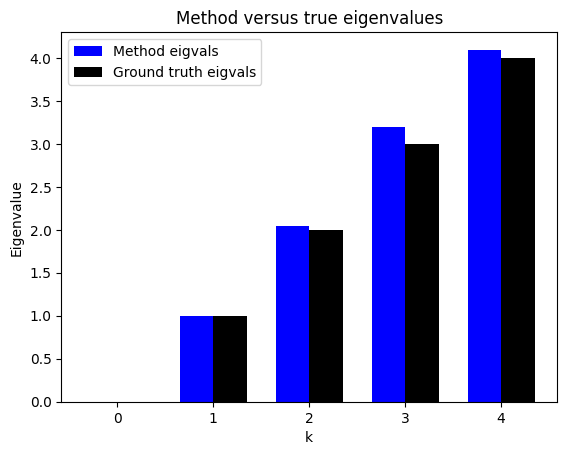

In [6]:
width = 0.35
plt.bar(torch.arange(k)-width/2,eigvals,width = width, label = "Method eigvals", color = "blue")
plt.bar(torch.arange(k)+width/2,exact_eigvals,width = width, label = "Ground truth eigvals", color='black')
plt.xlabel('k')
plt.ylabel('Eigenvalue')
plt.legend()
plt.title('Method versus true eigenvalues')


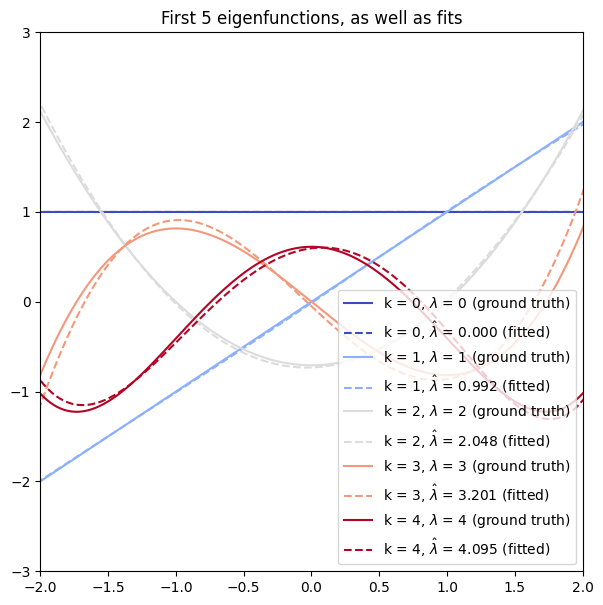

In [7]:
plt.rcParams['figure.figsize'] = [7, 7]

fitted_eigfuncs = basis(t) @ eigvecs
#fitted_eigfuncs = solver.predict(t)

# eigenfunctions are only determined up to sign
err = ((fitted_eigfuncs - exact_eigfuncs)**2).mean(dim=0)
neg_err = ((-fitted_eigfuncs - exact_eigfuncs)**2).mean(dim=0)

adjusted_fitted_eigfuncs = torch.where(err < neg_err, fitted_eigfuncs, -fitted_eigfuncs)

for i in range(k):
    plt.plot(t,exact_eigfuncs[:,i], label = f"k = {i}, $\\lambda$ = {exact_eigvals[i]:.0f} (ground truth)", color = colors[i])
    plt.plot(t,adjusted_fitted_eigfuncs[:,i], label = f"k = {i}, $\\hat\\lambda$ = {eigvals[i]:.3f} (fitted)", color = colors[i], ls = '--')

plt.legend(loc="lower right")
plt.title(f"First {k} eigenfunctions, as well as fits")
plt.xlim(-2,2)
plt.ylim(-3,3)
plt.legend()


All of the above is implemented in the <code>GalerkinSolver</code> class:

In [8]:
params = {
    'verbose': True,
    'num_samples': 10000
}

solver = GalerkinSolver(energy, samples, params)
solver = solver.fit(basis, k = k, L_reg = 1e-6, phi_reg= phi_reg, seed = 42)

# eigenfunctions might differ in sign
err = ((fitted_eigfuncs - solver.predict(t))**2).mean(dim=0)
neg_err = ((-fitted_eigfuncs - solver.predict(t))**2).mean(dim=0)
adjusted_fitted_eigfuncs = torch.where(err < neg_err, fitted_eigfuncs, -fitted_eigfuncs)

print(f"Mean absolute difference between previous and module fitted eigfunctions: {torch.mean(torch.abs(solver.predict(t) - adjusted_fitted_eigfuncs)):.3e}")
print(f"Mean absolute difference between previous and module fitted eigvalues: {torch.mean(torch.abs(solver.eigvals - eigvals)):.3e}")

Mean absolute difference between previous and module fitted eigfunctions: 4.186e-06
Mean absolute difference between previous and module fitted eigvalues: 5.534e-07


### Metrics

There are several different metrics we can consider to evaluate the quality of the learned eigensystem, which we consider here. They are implemented in the <code>EigenEvaluator</code> class.

In [9]:
evaluator = EigenEvaluator(energy)

#### MSE of eigenvalues/eigenfunctions

The most straightforward metric is the MSE of the learned eigenvalues/eigenfunctions. Note here that in general, eigenfunctions within an eigenspace (i.e. with the same eigenvalue) are only determined up to rotation (for $d=1$, up to sign), and hence we rotate the learned functions to match the true eigenfunctions as close as possible.

In [10]:
# manual calculation
manual_eigval_mse = torch.cumsum((eigvals-exact_eigvals)**2,0)/torch.arange(1,k+1)
print(f'Eigenvalue MSE: {manual_eigval_mse}')

x = energy.exact_sample((10000,))
fitted_eigfuncs = basis(x) @ eigvecs
exact_eigfuncs = energy.exact_eigfunctions(x, k)

# eigenfunctions are only determined up to sign
err = ((fitted_eigfuncs - exact_eigfuncs)**2).mean(dim=0)
neg_err = ((-fitted_eigfuncs - exact_eigfuncs)**2).mean(dim=0)

adjusted_fitted_eigfuncs = torch.where(err < neg_err, fitted_eigfuncs, -fitted_eigfuncs)

manual_eigfunc_mse = torch.cumsum(torch.mean((adjusted_fitted_eigfuncs-exact_eigfuncs)**2,dim=0),0)/torch.arange(1,k+1)
print(f'Eigenfunction MSE: {manual_eigfunc_mse}')


Eigenvalue MSE: tensor([2.3404e-13, 3.2892e-05, 7.7748e-04, 1.0699e-02, 1.0356e-02])
Eigenfunction MSE: tensor([2.5824e-09, 2.2916e-04, 7.9215e-04, 6.5627e-03, 7.4602e-03])


In [11]:
# evaluator

metrics = ['eigenvalue_mse', 'eigenfunc_mse']

display(evaluator.evaluate_metrics(solver, x, metrics, k))

{'eigenvalue_mse': tensor([1.0931e-12, 3.2892e-05, 7.7752e-04, 1.0699e-02, 1.0356e-02]),
 'eigenfunc_mse': tensor([2.5824e-09, 2.2916e-04, 7.9213e-04, 6.5627e-03, 7.4602e-03])}

#### Eigen error

The idea of this metric is that the defining property of an eigenfunction, $\mathcal{L}\phi = \lambda\phi$, is something that we can always check, even if we do not have access to the true eigensystem. Indeed, we can take some points $x \subset \mathbb{R}^d$ and see whether $\mathcal{L}\phi(x) \approx \lambda\phi(x)$. To make this more formal, we can fit the value $\hat\lambda$ which minimizes the squared error $\sum_{x} (\hat\lambda \phi(x) - \mathcal{L}\phi(x))^2$. The size of this squared error can then be considered as a metric for how much the function $\phi$ behaves like an eigenfunction, and $\lambda$ is an estimate of the eigenvalue based purely on evaluating $\phi$.

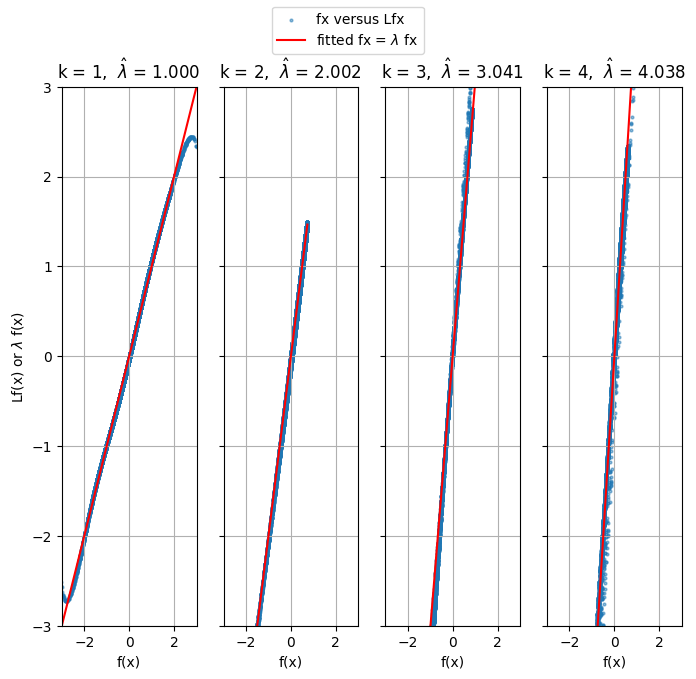

In [12]:
x = energy.exact_sample((10000,))
fitted_fx = solver.predict(x)
fitted_Lfx = solver.predict_Lf(x)

# closed form solution of OLS
fitted_eigvals = torch.sum(fitted_fx*fitted_Lfx,dim=0)/torch.sum(fitted_fx**2,dim=0)

fig, ax = plt.subplots(1,k-1,figsize=(8,7),sharey=True)

for i in range(1,k):
    ax[i-1].scatter(fitted_fx[:,i], fitted_Lfx[:,i],alpha=.5, label = "fx versus Lfx", s = 4)

    t = torch.linspace(fitted_fx[:,i].min(), fitted_fx[:,i].max(), 2).unsqueeze(1)
    ax[i-1].plot(t, fitted_eigvals[i]*t, color='red', label = f"fitted fx = $\\lambda$ fx")
    ax[i-1].set_xlabel('f(x)')
    ax[0].set_ylabel('Lf(x) or $\\lambda$ f(x)')
    ax[i-1].grid()
    ax[i-1].set_ylim(-3,3)
    ax[i-1].set_xlim(-3,3)
    ax[i-1].set_title(f'k = {i},  $\\hat\\lambda$ = {fitted_eigvals[i]:.3f}')
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

This is implemented in the <code>GalerkinSolver</code> class as well:

In [13]:
torch.allclose(solver.fit_eigvals(x), fitted_eigvals)

True

The graph below shows how the fitted eigenvalues compare to the true eigenvalues and method eigenvalues:

Text(0.5, 1.0, 'Fitted versus true eigenvalues')

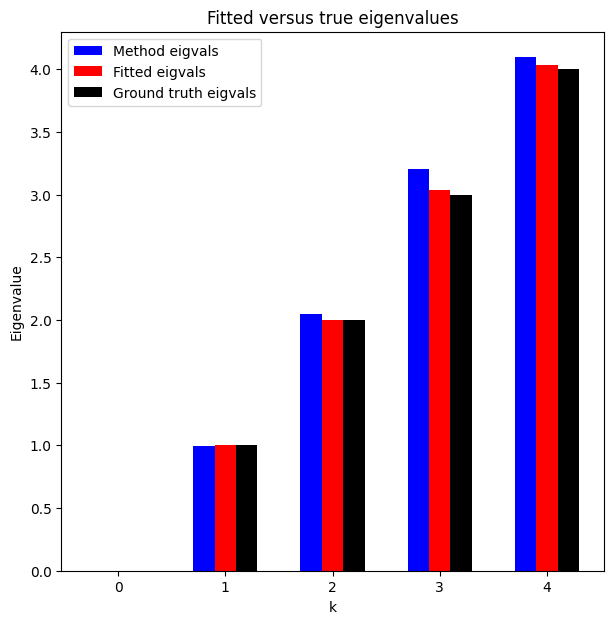

In [14]:
width = 0.2
plt.bar(torch.arange(k)-width,eigvals,width = width, label = "Method eigvals", color = "blue")
plt.bar(torch.arange(k),fitted_eigvals,width = width, label = "Fitted eigvals", color='red')
plt.bar(torch.arange(k)+width,exact_eigvals,width = width, label = "Ground truth eigvals", color='black')
plt.xlabel('k')
plt.ylabel('Eigenvalue')
plt.legend()
plt.title('Fitted versus true eigenvalues')


"fitting" the eigenvalues from the learned eigenfunction this way can lead to a more accurate estimate than the one produced by the method.

The evaluator class also contains functionality to evaluate these fitted eigenvalues (<code>fitted_eigenvalue_mse</code>) as well as assessing the quality of the fit (MSE) (<code>eigen_error</code> and <code>fitted_eigen_error</code>)

#### Orthogonality error

One thing to note is that the above metric can be misleading. For example, if we would have 'fitted' every eigenfunction as being constant, then we would have $\mathcal{L} \phi_i = 0$ for every $i$, and hence we could get a 'perfect' fit of $\mathcal{L} \phi_i \approx 0 \phi_i$. One way to verify that we are indeed learning different eigenfunctions is to check the orthogonality condition:
$$\quad <\phi_i, \phi_j>_\mu = \delta_{ij}$$
This inspires the metric
$$\text{orth error} = \|\mathbb{E}_{x\sim\mu}[\phi(x)^T\phi(x)] - I\|^2$$
where we have written $\phi = (\phi_1,\ldots,\phi_k)$.

In [15]:
x = energy.exact_sample((10000,))
fitted_fx = solver.predict(x)

cov_estimate = torch.mean(fitted_fx[:,:,None] * fitted_fx[:,None,:],dim=0)
manual_err = torch.mean((cov_estimate - torch.eye(k))**2)
print(f'Manual orth error: {manual_err:.5e}')

eval_err = evaluator.evaluate_metrics(solver, x, ['orth_error'], k = k)['orth_error'][-1]
print(f'Evaluator orth error: {eval_err:.5e}')

Manual orth error: 1.03464e-03
Evaluator orth error: 1.03465e-03


### Experiments

#### Setup

Now we can consider executing the method as described earlier, and observe the behaviour of the discussed errors as $p\to \infty$ (number of basis functions) and $n\to \infty$ (number of samples used in estimations).

In [19]:
# load in data
metrics = ['fitted_eigenvalue_mse','eigenvalue_mse','eigenfunc_mse',
           'fitted_eigen_error','eigen_error',
           'orth_error']

# Get the parent directory (one level above)
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)

dfs = []
for i in range(70):
    df = pd.read_csv(f'{parent_dir}/experiments/quadratic_energy/galerkin_1d/{i:04}.csv')
    dfs.append(df)

full_df = pd.concat(dfs)
full_df.dropna(inplace=True)
full_df_singlek = full_df.query('k==5')

# compute median error
mean_df = full_df_singlek.groupby(level=0).median()

# compute upper and lower quantiles
lq_df = mean_df.copy()
uq_df = mean_df.copy()
lq_df.loc[:,metrics] = full_df_singlek.groupby(level=0).quantile(0.05).loc[:,metrics]
uq_df.loc[:,metrics] = full_df_singlek.groupby(level=0).quantile(0.95).loc[:,metrics]

The following code finds the best value of $p$ for each choice of num_samples

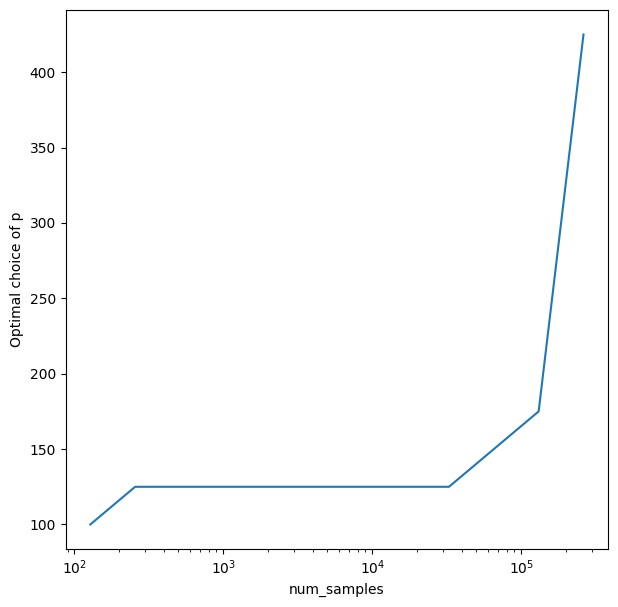

In [20]:
best_p = mean_df.pivot(index = 'num_samples', columns = 'p')['fitted_eigen_error'].idxmin(axis=1)
plt.plot(best_p)
plt.xscale('log')
plt.xlabel('num_samples')
plt.ylabel('Optimal choice of p')

best_p_idx = best_p[mean_df['num_samples']].values == mean_df['p']
bestp_mean_df = mean_df[best_p_idx].copy().sort_values('num_samples')
bestp_lq_df = lq_df[best_p_idx].copy().sort_values('num_samples')
bestp_uq_df = uq_df[best_p_idx].copy().sort_values('num_samples')

#### Increasing num_samples

We now investigate how the various metrics decay as we increase the number of samples used:

In [21]:
def plot_errorbar(ax, mean_df, lq_df, uq_df, param, metric, color):
    ax.errorbar(mean_df[param], 
             mean_df[metric], 
             yerr = [mean_df[metric]-lq_df[metric], uq_df[metric]-mean_df[metric]],
             capsize=4.0,
             color=color,
             label = metric)

Text(0.5, 0.98, 'Ground truth metrics as a function of num_samples (with 90% CI) (k = 5)')

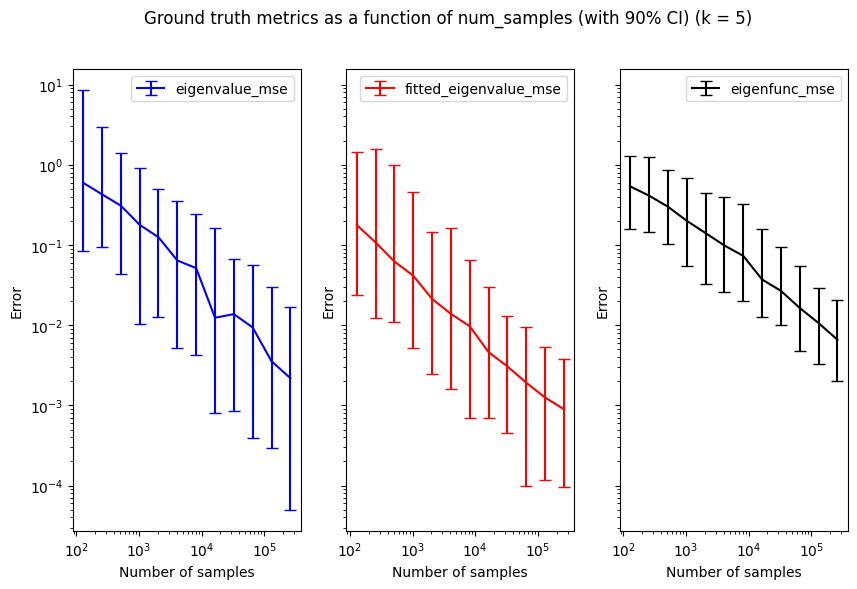

In [22]:
metrics = ['eigenvalue_mse', 'fitted_eigenvalue_mse', 'eigenfunc_mse']
colors = ['blue', 'red', 'black']

fig, axes = plt.subplots(1,len(metrics),figsize=(10,6),sharey=True)

param = 'num_samples'

for i, metric in enumerate(metrics):
    plot_errorbar(axes[i], bestp_mean_df, bestp_lq_df, bestp_uq_df, param, metric, colors[i])

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Error')

plt.suptitle(f'Ground truth metrics as a function of num_samples (with 90% CI) (k = {k})')

Thus, in this onedimensional case the error of each of our metrics decreases as we increase the number of samples. We can do the same for our non-exact metrics:

Text(0.5, 0.98, 'Non-ground truth metrics as a function of num_samples (with 90% CI) (k = 5)')

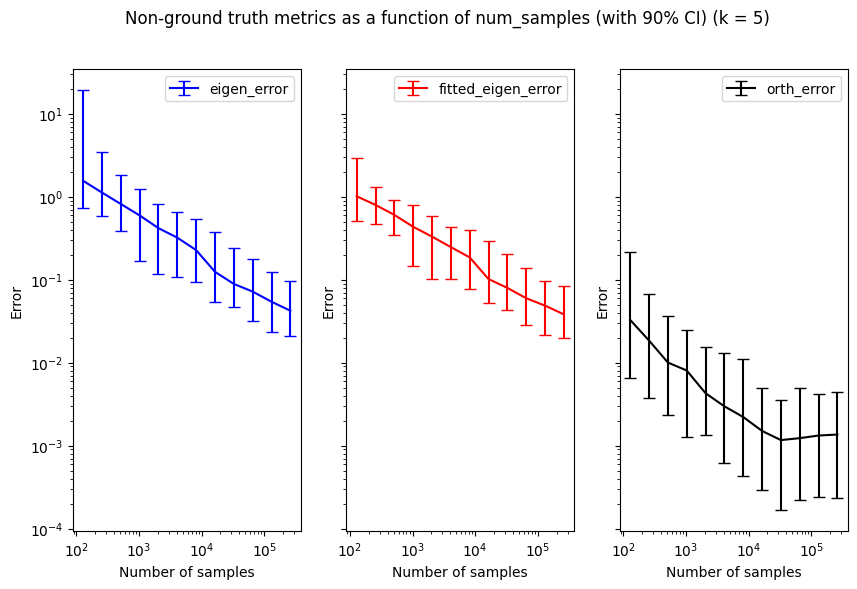

In [23]:
metrics = ['eigen_error', 'fitted_eigen_error', 'orth_error']
colors = ['blue', 'red', 'black']

fig, axes = plt.subplots(1,len(metrics),figsize=(10,6),sharey=True)

param = 'num_samples'

for i, metric in enumerate(metrics):
    plot_errorbar(axes[i], bestp_mean_df, bestp_lq_df, bestp_uq_df, param, metric, colors[i])

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Error')
plt.suptitle(f'Non-ground truth metrics as a function of num_samples (with 90% CI) (k = {k})')

#### Comparing metrics

The code below highlights that our ground truth metric (eigenvalue MSE) correlated well with our non-ground truth metric (eigen_error), as also indicated in the previous plot.

Text(0.5, 1.0, 'Comparison between ground truth metrics and non-ground truth')

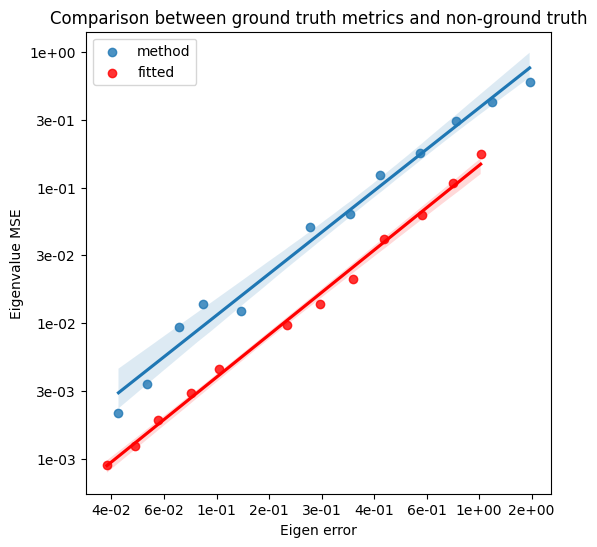

In [24]:
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(6,6))

metrics = ['eigen_error', 'eigenvalue_mse', 'fitted_eigen_error', 'fitted_eigenvalue_mse']
for metric in metrics:
    bestp_mean_df[f'log_{metric}'] = np.log10(bestp_mean_df[metric])

sns.regplot(bestp_mean_df,x='log_eigen_error', y='log_eigenvalue_mse', ax = ax, label = 'method')
sns.regplot(bestp_mean_df,x='log_fitted_eigen_error', y='log_fitted_eigenvalue_mse', ax = ax, color = 'red', label = 'fitted')

# Function to format ticks back to the original scale
def exp_format(val, pos):
    return f"{10**(val):.0e}"  # Format tick labels with exponential values

# Apply the formatter to the axes
plt.gca().xaxis.set_major_formatter(FuncFormatter(exp_format))
plt.gca().yaxis.set_major_formatter(FuncFormatter(exp_format))

ax.legend()
ax.set_xlabel('Eigen error')
ax.set_ylabel('Eigenvalue MSE')
ax.set_title('Comparison between ground truth metrics and non-ground truth')

#### Increasing $k$

Finally, we can consider how the error of various metrics changes as $k$ increases. We expect that larger eigenfunctions are more difficult to learn.

In [25]:
# compute median error
mean_df = full_df.groupby(level=0).median()

# take best largest value of p and num_sampes
mean_df = mean_df[(mean_df['p'] == mean_df['p'].max()) & (mean_df['num_samples'] == mean_df['num_samples'].max())].copy()

# compute upper and lower quantiles
lq_df = mean_df.copy()
uq_df = mean_df.copy()
lq_df.loc[:,metrics] = full_df.groupby(level=0).quantile(0.05).loc[:,metrics]
uq_df.loc[:,metrics] = full_df.groupby(level=0).quantile(0.95).loc[:,metrics]

Text(0.5, 0.98, 'Ground truth metrics as a function of k (with 90% CI) (k = 5)')

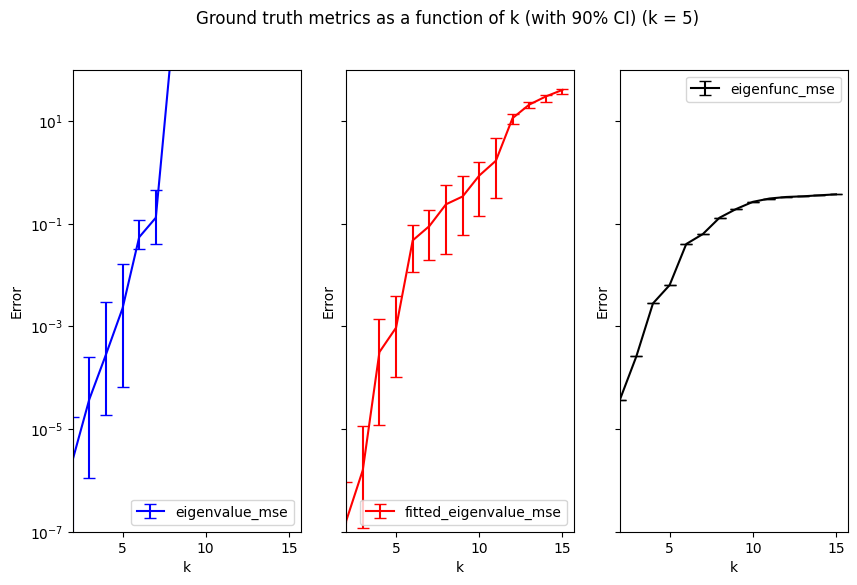

In [26]:
metrics = ['eigenvalue_mse', 'fitted_eigenvalue_mse', 'eigenfunc_mse']
colors = ['blue', 'red', 'black']

fig, axes = plt.subplots(1,len(metrics),figsize=(10,6),sharey=True)

param = 'k'

for i, metric in enumerate(metrics):
    plot_errorbar(axes[i], mean_df, lq_df, uq_df, param, metric, colors[i])

for ax in axes:
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('k')
    ax.set_ylabel('Error')
    ax.set_xlim(2,)
    ax.set_ylim(1e-7,1e2)
plt.suptitle(f'Ground truth metrics as a function of k (with 90% CI) (k = {k})')

Text(0.5, 0.98, 'Non-ground truth metrics as a function of k (with 90% CI) (k = 5)')

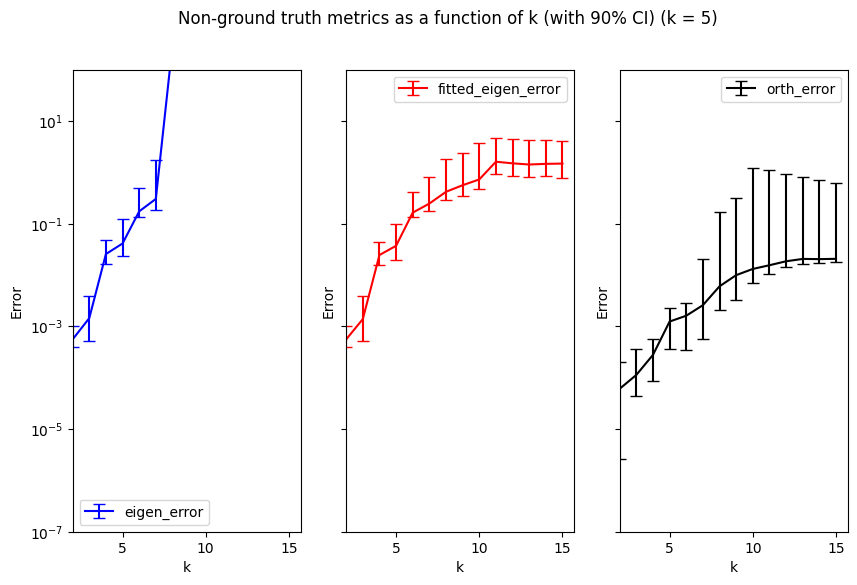

In [122]:
metrics = ['eigen_error', 'fitted_eigen_error', 'orth_error']
colors = ['blue', 'red', 'black']

fig, axes = plt.subplots(1,len(metrics),figsize=(10,6),sharey=True)

param = 'k'

for i, metric in enumerate(metrics):
    plot_errorbar(axes[i], mean_df, lq_df, uq_df, param, metric, colors[i])

for ax in axes:
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('k')
    ax.set_ylabel('Error')
    ax.set_xlim(2,)
    ax.set_ylim(1e-7,1e2)
plt.suptitle(f'Non-ground truth metrics as a function of k (with 90% CI) (k = {k})')

We see that the method begins to perform poorly as the number of estimated eigenfunctions $k$ is increased. In particular, the method eigenvalue becomes an extremely bad estimator, especially when compared with the fitted eigenvalue.

## Two dimensions

We can of course apply this methodology to higher dimensions. This section illustrates the workflow for $d = 2$.

### Demo

Text(0.5, 1.0, 'Samples from 2-dimensional Gaussian')

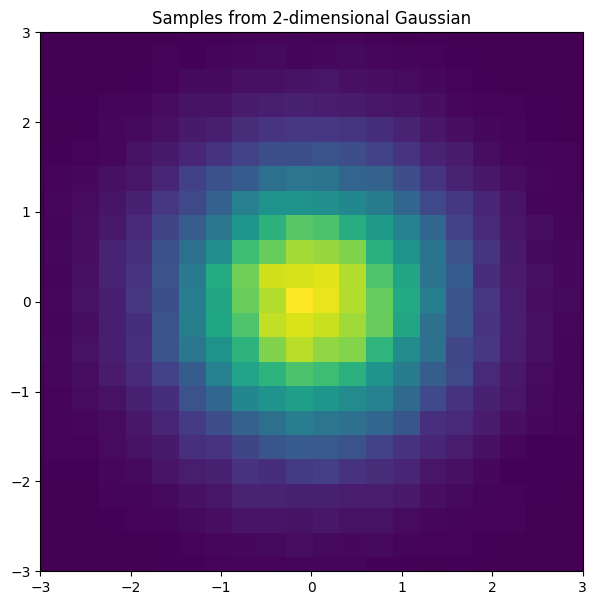

In [27]:
# define energy
energy = QuadraticEnergy(torch.eye(2))

samples = energy.exact_sample((100000,))
plt.hist2d(samples[:,0], samples[:,1],bins=30,density=True)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title('Samples from 2-dimensional Gaussian')

In [28]:
# define kernel basis
p = 50

kernel_params = {
    'dim': 2,
    'scale': 4.0,
}

kernel = GaussianKernel(kernel_params)

basis_points = energy.exact_sample((p,))

kernel_basis = KernelBasis(kernel, basis_points)

basis = ConstantBasis(kernel_basis)

/home/lclaeys/miniconda3/envs/efs-env/lib/python3.13/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


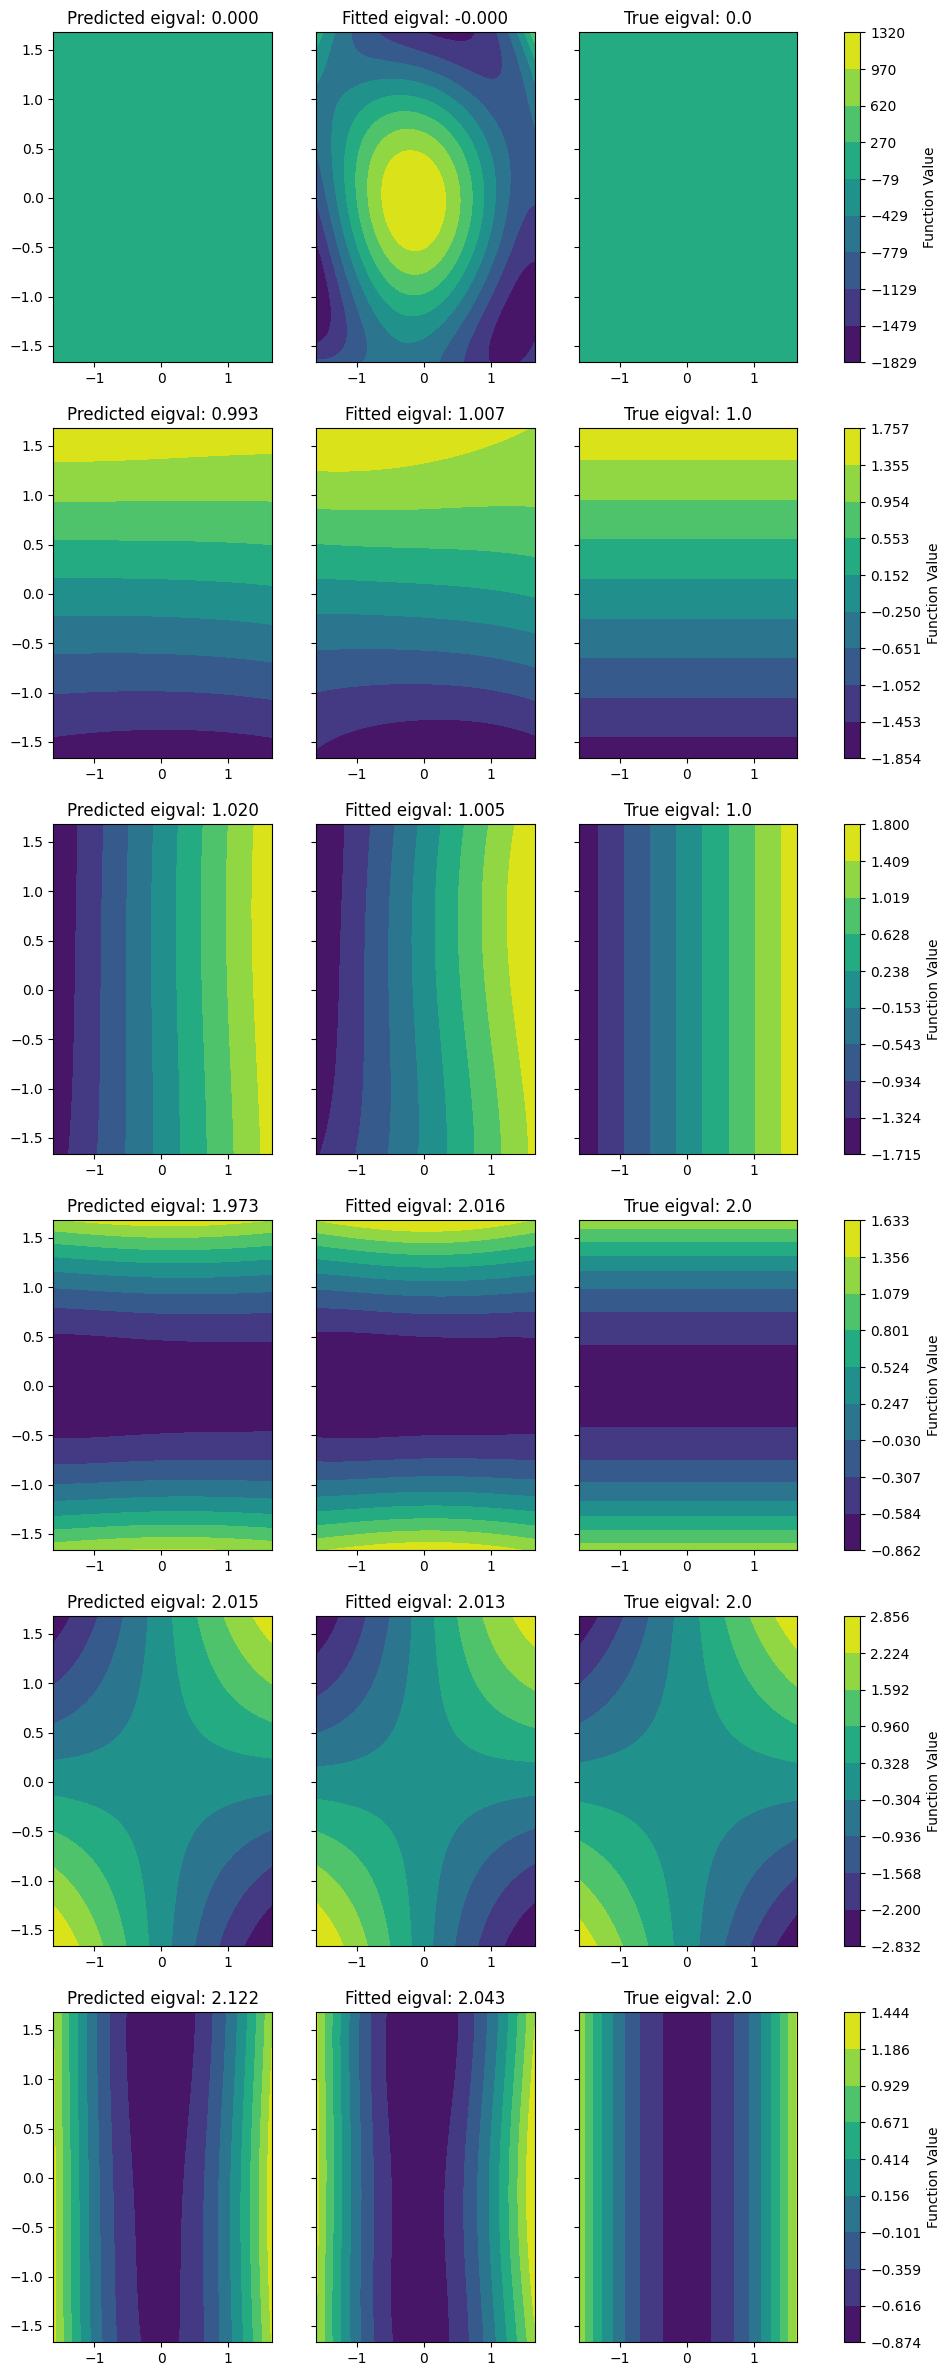

In [29]:
# define solver object
samples = energy.exact_sample((10000,))

params = {
    'verbose': True,
    'num_samples': 10000
}

solver = GalerkinSolver(energy, samples, params)

k = 6
solver.fit(basis, k = k, L_reg = 1e-6)

# define evaluator object
evaluator = EigenEvaluator(energy)

# the plot function plots the predicted eigenfunctions, Lf_i/lambda_i for each eigenfunction, as well as the true eigenfunctions.
evaluator.plot(solver, samples, k, plot_exact=True, plot_Lf = True)
plt.show()

### Experiments

As before, we can analyze the performance more rigorously by examing the various metrics for many fits.

In [40]:
# load in data
metrics = ['fitted_eigenvalue_mse','eigenvalue_mse','eigenfunc_mse',
           'fitted_eigen_error','eigen_error',
           'orth_error']

# Get the parent directory (one level above)
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)

dfs = []
for i in range(70):
    df = pd.read_csv(f'{parent_dir}/experiments/quadratic_energy/galerkin_2d/{i:04}.csv')
    dfs.append(df)

k = 10
full_df = pd.concat(dfs)
full_df.dropna(inplace=True)
full_df_singlek = full_df.query(f'k=={k}')

# compute median error
mean_df = full_df_singlek.groupby(level=0).median()

# compute upper and lower quantiles
lq_df = mean_df.copy()
uq_df = mean_df.copy()
lq_df.loc[:,metrics] = full_df_singlek.groupby(level=0).quantile(0.05).loc[:,metrics]
uq_df.loc[:,metrics] = full_df_singlek.groupby(level=0).quantile(0.95).loc[:,metrics]

The following code finds the best value of $p$ for each choice of num_samples

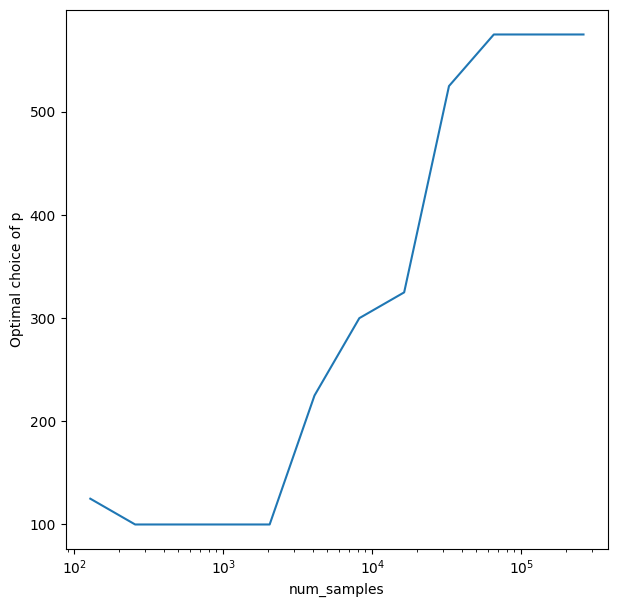

In [31]:
best_p = mean_df.pivot(index = 'num_samples', columns = 'p')['fitted_eigen_error'].idxmin(axis=1)
plt.plot(best_p)
plt.xscale('log')
plt.xlabel('num_samples')
plt.ylabel('Optimal choice of p')

best_p_idx = best_p[mean_df['num_samples']].values == mean_df['p']
bestp_mean_df = mean_df[best_p_idx].copy().sort_values('num_samples')
bestp_lq_df = lq_df[best_p_idx].copy().sort_values('num_samples')
bestp_uq_df = uq_df[best_p_idx].copy().sort_values('num_samples')

#### Increasing num_samples

In [33]:
def plot_errorbar(ax, mean_df, lq_df, uq_df, param, metric, color):
    ax.errorbar(mean_df[param], 
             mean_df[metric], 
             yerr = [mean_df[metric]-lq_df[metric], uq_df[metric]-mean_df[metric]],
             capsize=4.0,
             color=color,
             label = metric)

Text(0.5, 0.98, 'Ground truth metrics as a function of num_samples (with 90% CI) (k = 10)')

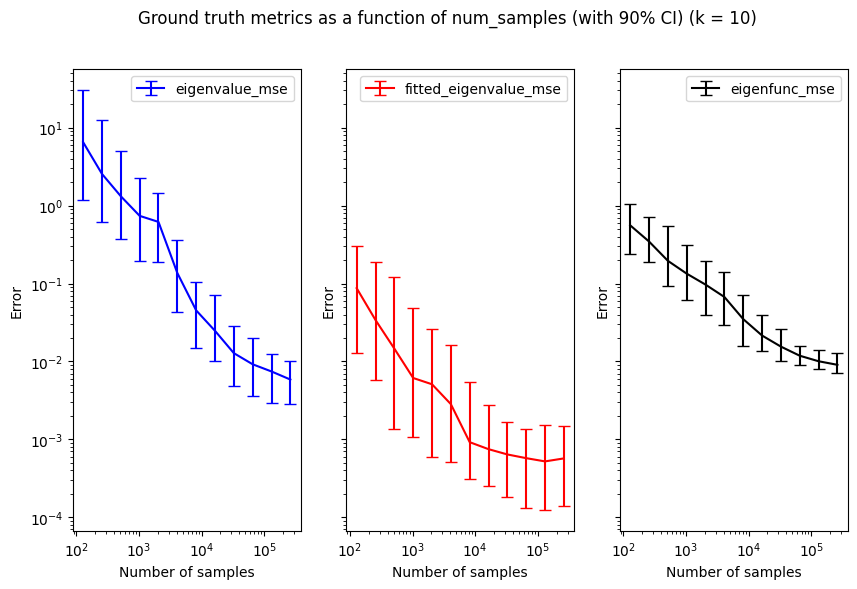

In [34]:
metrics = ['eigenvalue_mse', 'fitted_eigenvalue_mse', 'eigenfunc_mse']
colors = ['blue', 'red', 'black']

fig, axes = plt.subplots(1,len(metrics),figsize=(10,6),sharey=True)

param = 'num_samples'

for i, metric in enumerate(metrics):
    plot_errorbar(axes[i], bestp_mean_df, bestp_lq_df, bestp_uq_df, param, metric, colors[i])

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Error')

plt.suptitle(f'Ground truth metrics as a function of num_samples (with 90% CI) (k = {k})')

Text(0.5, 0.98, 'Non-ground truth metrics as a function of num_samples (with 90% CI) (k = 10)')

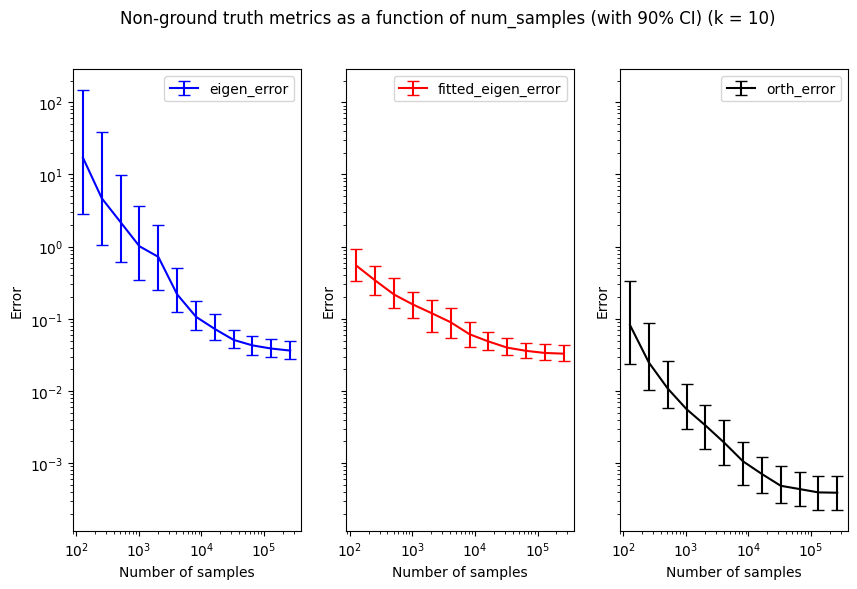

In [35]:
metrics = ['eigen_error', 'fitted_eigen_error', 'orth_error']
colors = ['blue', 'red', 'black']

fig, axes = plt.subplots(1,len(metrics),figsize=(10,6),sharey=True)

param = 'num_samples'

for i, metric in enumerate(metrics):
    plot_errorbar(axes[i], bestp_mean_df, bestp_lq_df, bestp_uq_df, param, metric, colors[i])

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Error')
plt.suptitle(f'Non-ground truth metrics as a function of num_samples (with 90% CI) (k = {k})')

#### Comparing metrics

Text(0.5, 1.0, 'Comparison between ground truth metrics and non-ground truth')

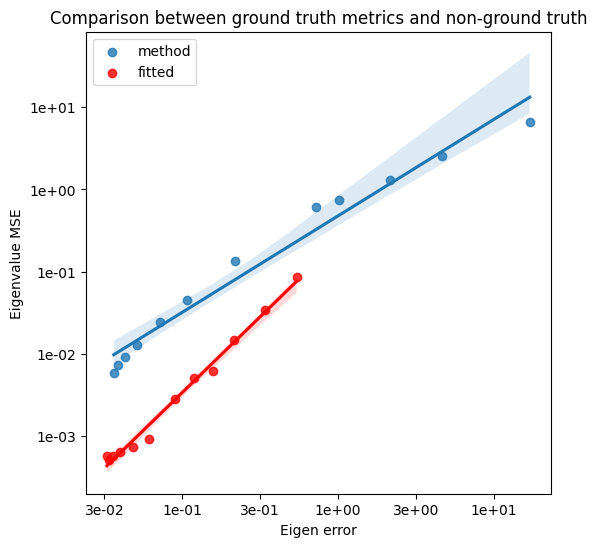

In [36]:
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(6,6))

metrics = ['eigen_error', 'eigenvalue_mse', 'fitted_eigen_error', 'fitted_eigenvalue_mse']
for metric in metrics:
    bestp_mean_df[f'log_{metric}'] = np.log10(bestp_mean_df[metric])

sns.regplot(bestp_mean_df,x='log_eigen_error', y='log_eigenvalue_mse', ax = ax, label = 'method')
sns.regplot(bestp_mean_df,x='log_fitted_eigen_error', y='log_fitted_eigenvalue_mse', ax = ax, color = 'red', label = 'fitted')

# Function to format ticks back to the original scale
def exp_format(val, pos):
    return f"{10**(val):.0e}"  # Format tick labels with exponential values

# Apply the formatter to the axes
plt.gca().xaxis.set_major_formatter(FuncFormatter(exp_format))
plt.gca().yaxis.set_major_formatter(FuncFormatter(exp_format))

ax.legend()
ax.set_xlabel('Eigen error')
ax.set_ylabel('Eigenvalue MSE')
ax.set_title('Comparison between ground truth metrics and non-ground truth')

#### Increasing $k$

In [41]:
# compute median error
mean_df = full_df.groupby(level=0).median()

# take best largest value of p and num_sampes
mean_df = mean_df[(mean_df['p'] == mean_df['p'].max()) & (mean_df['num_samples'] == mean_df['num_samples'].max())].copy()

# compute upper and lower quantiles
lq_df = mean_df.copy()
uq_df = mean_df.copy()
lq_df.loc[:,metrics] = full_df.groupby(level=0).quantile(0.05).loc[:,metrics]
uq_df.loc[:,metrics] = full_df.groupby(level=0).quantile(0.95).loc[:,metrics]

Text(0.5, 0.98, 'Ground truth metrics as a function of k (with 90% CI)')

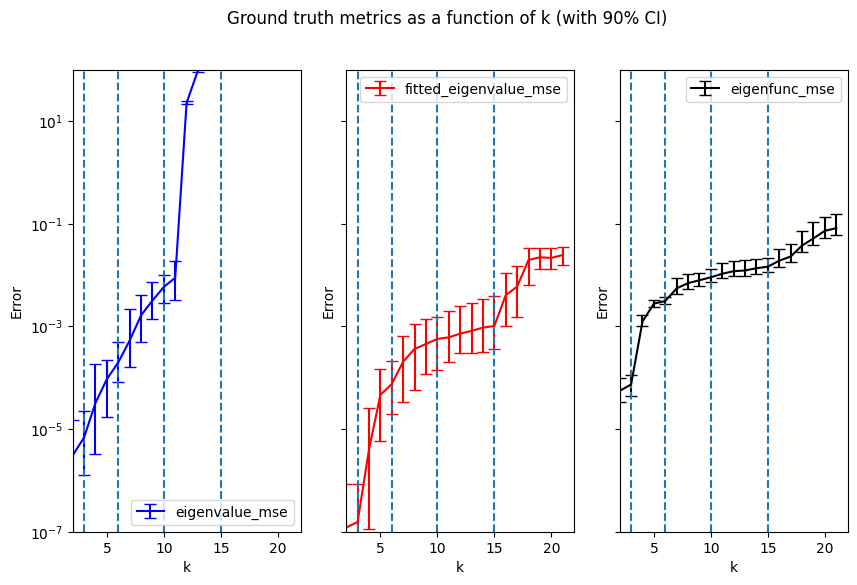

In [42]:
metrics = ['eigenvalue_mse', 'fitted_eigenvalue_mse', 'eigenfunc_mse']
colors = ['blue', 'red', 'black']

fig, axes = plt.subplots(1,len(metrics),figsize=(10,6),sharey=True)

param = 'k'

for i, metric in enumerate(metrics):
    plot_errorbar(axes[i], mean_df, lq_df, uq_df, param, metric, colors[i])

for ax in axes:
    ax.vlines(3,1e-7,1e2, ls='--')
    ax.vlines(6,1e-7,1e2, ls='--')
    ax.vlines(10,1e-7,1e2, ls='--')
    ax.vlines(15,1e-7,1e2, ls='--')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('k')
    ax.set_ylabel('Error')
    ax.set_xlim(2,)
    ax.set_ylim(1e-7,1e2)
plt.suptitle(f'Ground truth metrics as a function of k (with 90% CI)')

Text(0.5, 0.98, 'Non-ground truth metrics as a function of k (with 90% CI)')

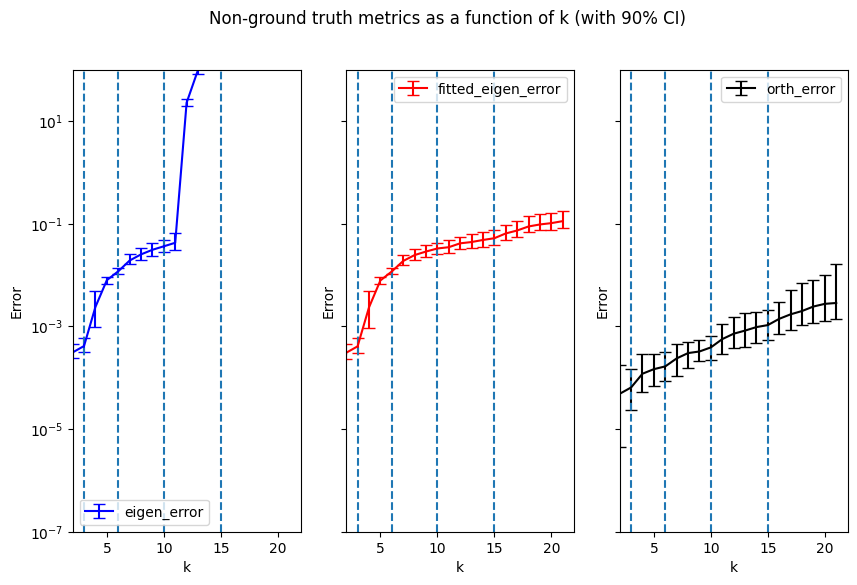

In [43]:
metrics = ['eigen_error', 'fitted_eigen_error', 'orth_error']
colors = ['blue', 'red', 'black']

fig, axes = plt.subplots(1,len(metrics),figsize=(10,6),sharey=True)

param = 'k'

for i, metric in enumerate(metrics):
    plot_errorbar(axes[i], mean_df, lq_df, uq_df, param, metric, colors[i])

for ax in axes:
    ax.vlines(3,1e-7,1e2, ls='--')
    ax.vlines(6,1e-7,1e2, ls='--')
    ax.vlines(10,1e-7,1e2, ls='--')
    ax.vlines(15,1e-7,1e2, ls='--')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('k')
    ax.set_ylabel('Error')
    ax.set_xlim(2,)
    ax.set_ylim(1e-7,1e2)
plt.suptitle(f'Non-ground truth metrics as a function of k (with 90% CI)')

### d = 20

In [65]:
# load in data
metrics = ['fitted_eigenvalue_mse','eigenvalue_mse','eigenfunc_mse',
           'fitted_eigen_error','eigen_error',
           'orth_error']

# Get the parent directory (one level above)
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)

dfs = []
for i in range(1):
    df = pd.read_csv(f'{parent_dir}/experiments/quadratic_energy/galerkin_20d/{i:04}.csv')
    dfs.append(df)

k = 1+20+21*20//2
full_df = pd.concat(dfs)
full_df.dropna(inplace=True)
full_df_singlek = full_df.query(f'k=={k}')

# compute median error
mean_df = full_df_singlek.groupby(level=0).median()

# compute upper and lower quantiles
lq_df = mean_df.copy()
uq_df = mean_df.copy()
lq_df.loc[:,metrics] = full_df_singlek.groupby(level=0).quantile(0.05).loc[:,metrics]
uq_df.loc[:,metrics] = full_df_singlek.groupby(level=0).quantile(0.95).loc[:,metrics]

The following code finds the best value of $p$ for each choice of num_samples

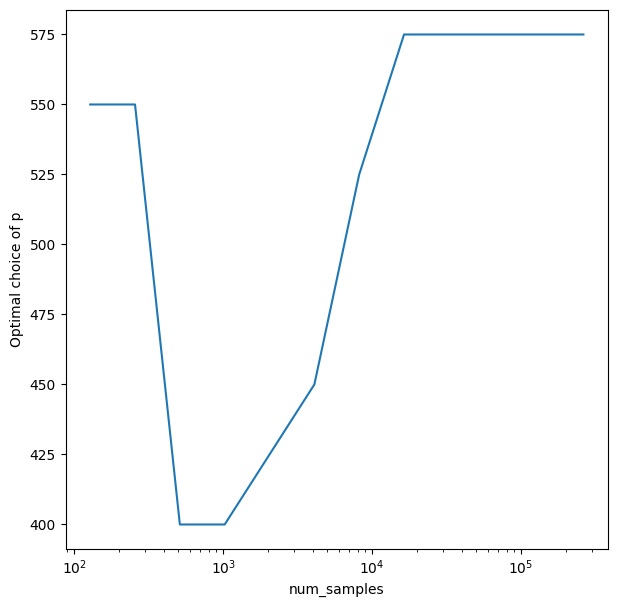

In [66]:
best_p = mean_df.pivot(index = 'num_samples', columns = 'p')['fitted_eigen_error'].idxmin(axis=1)
plt.plot(best_p)
plt.xscale('log')
plt.xlabel('num_samples')
plt.ylabel('Optimal choice of p')

best_p_idx = best_p[mean_df['num_samples']].values == mean_df['p']
bestp_mean_df = mean_df[best_p_idx].copy().sort_values('num_samples')
bestp_lq_df = lq_df[best_p_idx].copy().sort_values('num_samples')
bestp_uq_df = uq_df[best_p_idx].copy().sort_values('num_samples')

#### Increasing num_samples

In [67]:
def plot_errorbar(ax, mean_df, lq_df, uq_df, param, metric, color):
    ax.errorbar(mean_df[param], 
             mean_df[metric], 
             yerr = [mean_df[metric]-lq_df[metric], uq_df[metric]-mean_df[metric]],
             capsize=4.0,
             color=color,
             label = metric)

Text(0.5, 0.98, 'Ground truth metrics as a function of num_samples (with 90% CI) (k = 231)')

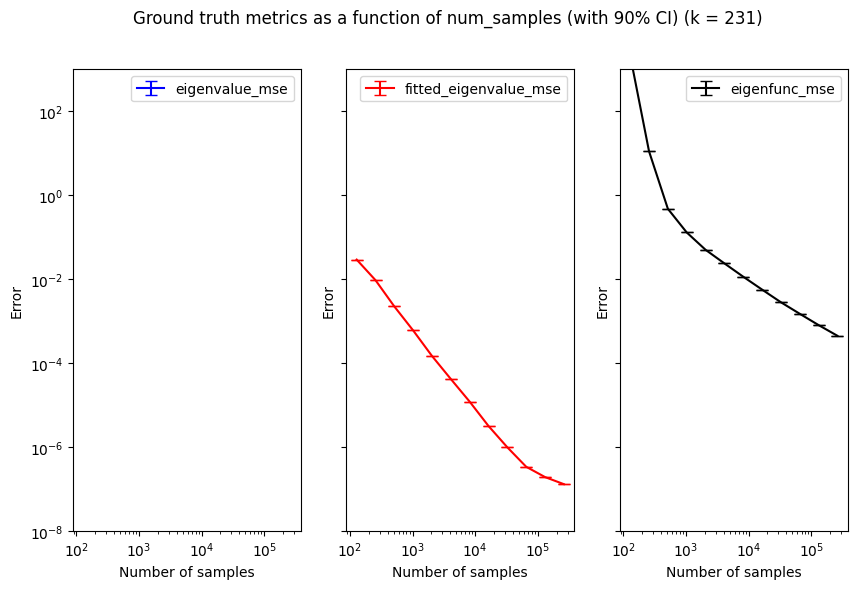

In [71]:
metrics = ['eigenvalue_mse', 'fitted_eigenvalue_mse', 'eigenfunc_mse']
colors = ['blue', 'red', 'black']

fig, axes = plt.subplots(1,len(metrics),figsize=(10,6),sharey=True)

param = 'num_samples'

for i, metric in enumerate(metrics):
    plot_errorbar(axes[i], bestp_mean_df, bestp_lq_df, bestp_uq_df, param, metric, colors[i])

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Error')
    ax.set_ylim(1e-8,1e3)

plt.suptitle(f'Ground truth metrics as a function of num_samples (with 90% CI) (k = {k})')

Text(0.5, 0.98, 'Non-ground truth metrics as a function of num_samples (with 90% CI) (k = 231.0)')

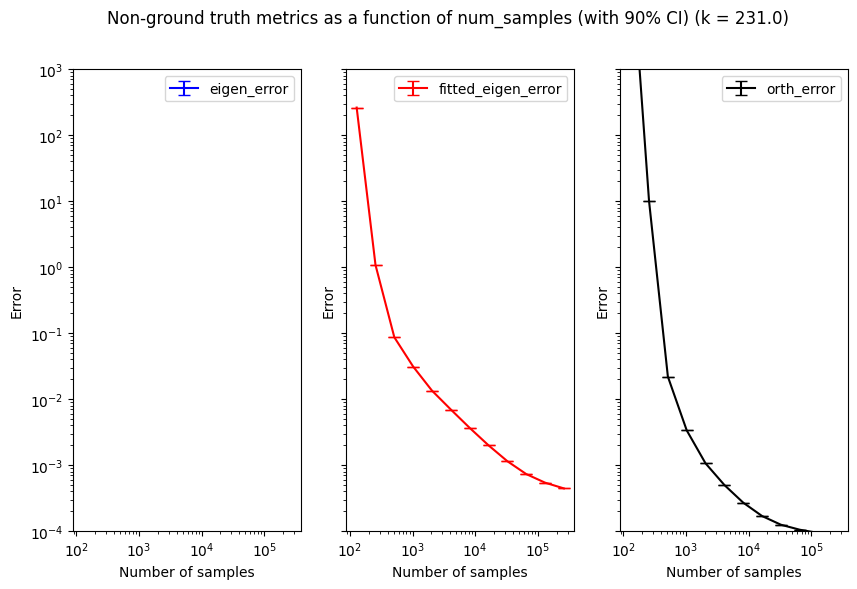

In [64]:
metrics = ['eigen_error', 'fitted_eigen_error', 'orth_error']
colors = ['blue', 'red', 'black']

fig, axes = plt.subplots(1,len(metrics),figsize=(10,6),sharey=True)

param = 'num_samples'

for i, metric in enumerate(metrics):
    plot_errorbar(axes[i], bestp_mean_df, bestp_lq_df, bestp_uq_df, param, metric, colors[i])

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Error')
    ax.set_ylim(1e-4,1e3)
plt.suptitle(f'Non-ground truth metrics as a function of num_samples (with 90% CI) (k = {k})')

#### Comparing metrics

Text(0.5, 1.0, 'Comparison between ground truth metrics and non-ground truth')

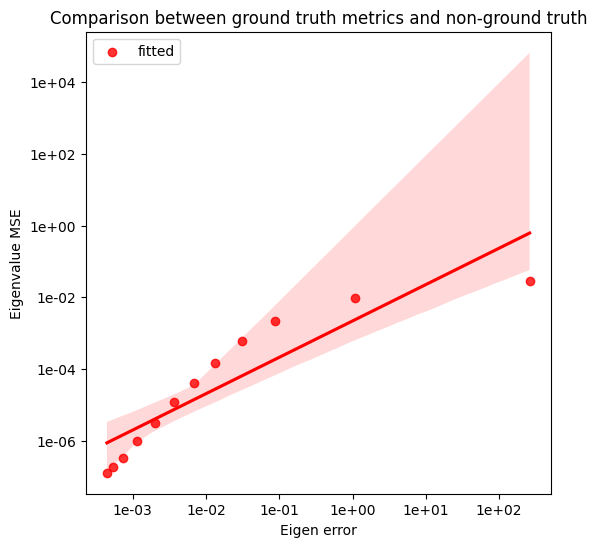

In [55]:
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(6,6))

metrics = ['eigen_error', 'eigenvalue_mse', 'fitted_eigen_error', 'fitted_eigenvalue_mse']
for metric in metrics:
    bestp_mean_df[f'log_{metric}'] = np.log10(bestp_mean_df[metric])

#sns.regplot(bestp_mean_df,x='log_eigen_error', y='log_eigenvalue_mse', ax = ax, label = 'method')
sns.regplot(bestp_mean_df,x='log_fitted_eigen_error', y='log_fitted_eigenvalue_mse', ax = ax, color = 'red', label = 'fitted')

# Function to format ticks back to the original scale
def exp_format(val, pos):
    return f"{10**(val):.0e}"  # Format tick labels with exponential values

# Apply the formatter to the axes
plt.gca().xaxis.set_major_formatter(FuncFormatter(exp_format))
plt.gca().yaxis.set_major_formatter(FuncFormatter(exp_format))

ax.legend()
ax.set_xlabel('Eigen error')
ax.set_ylabel('Eigenvalue MSE')
ax.set_title('Comparison between ground truth metrics and non-ground truth')

#### Increasing $k$

In [56]:
# compute median error
mean_df = full_df.groupby(level=0).median()

# take best largest value of p and num_sampes
mean_df = mean_df[(mean_df['p'] == mean_df['p'].max()) & (mean_df['num_samples'] == mean_df['num_samples'].max())].copy()

# compute upper and lower quantiles
lq_df = mean_df.copy()
uq_df = mean_df.copy()
lq_df.loc[:,metrics] = full_df.groupby(level=0).quantile(0.05).loc[:,metrics]
uq_df.loc[:,metrics] = full_df.groupby(level=0).quantile(0.95).loc[:,metrics]

Text(0.5, 0.98, 'Ground truth metrics as a function of k (with 90% CI)')

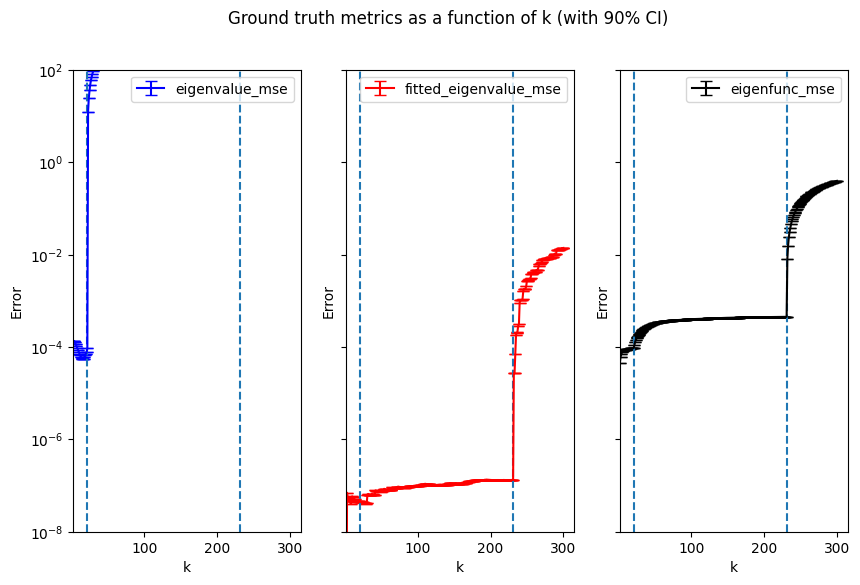

In [60]:
metrics = ['eigenvalue_mse', 'fitted_eigenvalue_mse', 'eigenfunc_mse']
colors = ['blue', 'red', 'black']

fig, axes = plt.subplots(1,len(metrics),figsize=(10,6),sharey=True)

param = 'k'

for i, metric in enumerate(metrics):
    plot_errorbar(axes[i], mean_df, lq_df, uq_df, param, metric, colors[i])

for ax in axes:
    ax.vlines(21,1e-8,1e2, ls='--')
    ax.vlines(21+20*21/2,1e-8,1e2, ls='--')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('k')
    ax.set_ylabel('Error')
    ax.set_xlim(2,)
    ax.set_ylim(1e-8,1e2)
plt.suptitle(f'Ground truth metrics as a function of k (with 90% CI)')

Text(0.5, 0.98, 'Non-ground truth metrics as a function of k (with 90% CI)')

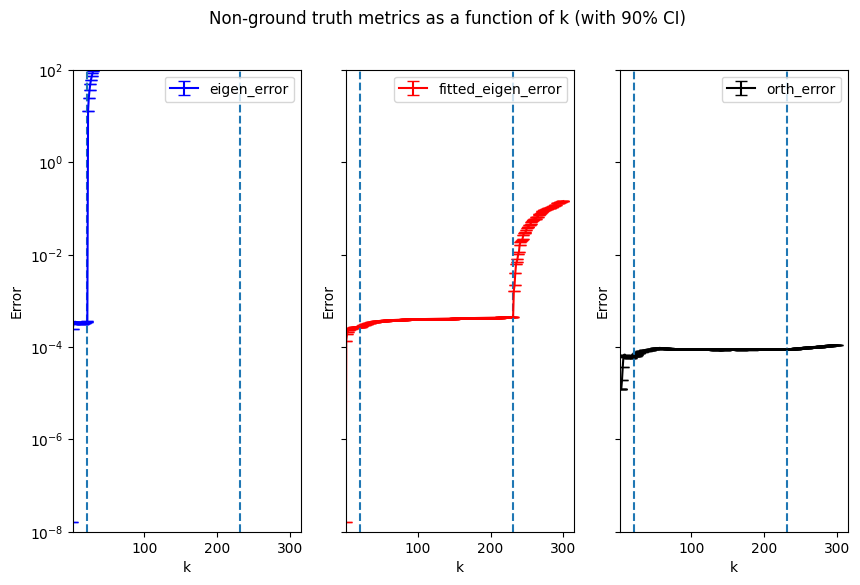

In [62]:
metrics = ['eigen_error', 'fitted_eigen_error', 'orth_error']
colors = ['blue', 'red', 'black']

fig, axes = plt.subplots(1,len(metrics),figsize=(10,6),sharey=True)

param = 'k'

for i, metric in enumerate(metrics):
    plot_errorbar(axes[i], mean_df, lq_df, uq_df, param, metric, colors[i])

for ax in axes:
    ax.vlines(21,1e-8,1e2, ls='--')
    ax.vlines(21+20*21/2,1e-8,1e2, ls='--')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('k')
    ax.set_ylabel('Error')
    ax.set_xlim(2,)
    ax.set_ylim(1e-8,1e2)
plt.suptitle(f'Non-ground truth metrics as a function of k (with 90% CI)')

In [2]:
energy = QuadraticEnergy(torch.eye(1))

In [23]:
p = 100

kernel_params = {
    'dim': 1,
    'scale': 2.0,
}

kernel = GaussianKernel(kernel_params)

basis_points = energy.exact_sample((p,))

kernel_basis = KernelBasis(kernel, basis_points)

# add constant function
basis = ConstantBasis(kernel_basis)

(EXTRA test): what if we consider instead the operator $\tilde{\mathcal{L}} = \mathcal{L} + \mathcal{R}$, where $\mathcal{R}u = Ru$ for some cost function $R: \mathbb{R}^d \to \mathbb{R}$. In this case we have
$$<f, \tilde{\mathcal{L}}g>_\mu = <\nabla f, \nabla g>_\mu + <f, Rg>_\mu$$
In the example below, we take $R(x) = \|x\|^2$.

In [24]:
from scipy.linalg import eigh

k = 5
torch.manual_seed(42)
samples = energy.exact_sample((100000,)).double()

grad_basis = basis.grad(samples)
L = torch.bmm(grad_basis, grad_basis.transpose(1,2)).mean(dim=0)

eval_basis = basis(samples)
Phi = torch.mean(eval_basis[:,:,None]*eval_basis[:,None,:],dim=0)

def R_func(x):
    #return smooth_quadratic_with_bumps(x[:,0])*5-0.634 
    return torch.norm(x,dim=1)**2
    #return torch.where(torch.norm(x,dim=1) < 1, torch.norm(x,dim=1)**2, 2*torch.norm(x,dim=1)-1)

R = R_func(samples)
Ltilde = L + torch.mean(eval_basis[:,:,None]*eval_basis[:,None,:]*R[:,None,None],dim=0)

# Phi and L should both be semi-positive definite, but this can be violated due to numerical errors.

phi_error = torch.linalg.eigvalsh(Phi)[0]
if phi_error >= 0:
    print('Phi is spd.')
else:
    phi_reg = -2*phi_error
    print(f'Phi is not spd, adding regularizer {phi_reg}')
    Phi = Phi + phi_reg*torch.eye(Phi.size(0),dtype=torch.float64)

Ltilde = Ltilde + 1e-6 * torch.eye(L.size(0),dtype=torch.float64)

# use scipy.eigh to solve generalized eigenvalue problem.
Ltilde, Phi = Ltilde.numpy(), Phi.numpy()
eigvals, eigvecs = eigh(Ltilde, Phi, subset_by_index=[0, k-1])

eigvals, eigvecs = torch.tensor(eigvals, dtype = torch.float32), torch.tensor(eigvecs, dtype = torch.float32)

Phi is not spd, adding regularizer 1.2418959018493623e-14


In [12]:
colormap_name = 'coolwarm'
colormap = plt.get_cmap(colormap_name)

colors = [colormap(i / (k - 1)) for i in range(k)]

In [19]:
import math

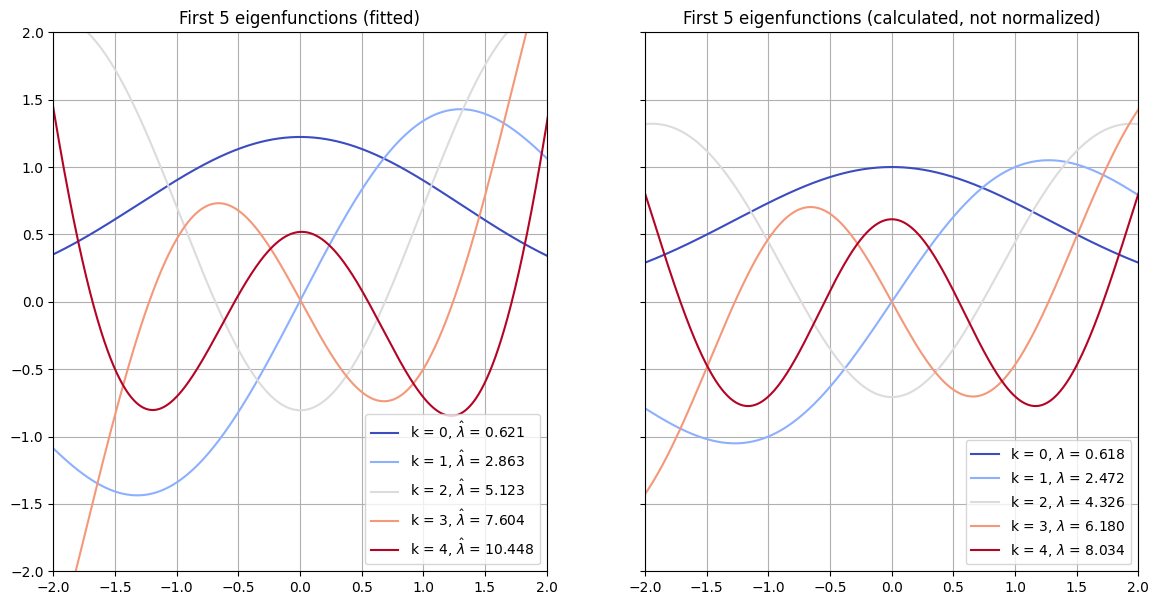

In [27]:
fig, ax = plt.subplots(1,2,figsize=(14,7),sharey=True,sharex=True)
params = {
    'verbose': True,
    'num_samples': 10000
}

t = torch.linspace(-3,3,1000)[:,None]

solver = GalerkinSolver(energy, samples, params)
solver = solver.fit(basis, k, L_reg=1e-6)

solver.eigvecs = eigvecs

#ax[0].plot(t,solver.predict(t)[:,0], label = f"k = {0}, $\\hat\\lambda$ = {eigvals[0]:.3f}", color = colors[0], ls = '-')
#ax[0].plot(t,Ltilde[:,0], label = f"k = {0}, Lfx", color = colors[0], ls = '--')
#ax[0].plot(t,solver.predict_grad(t)[:,0,0]/solver.predict(t)[:,0], color = colors[0], ls = '-.')


astar = (-1 + math.sqrt(5))/2
exact_fx = energy.exact_eigfunctions(math.sqrt(3*astar)*t, k) * torch.exp(-1/2*astar*t.norm(dim=1)**2)[:,None]
exact_eigvals = (3*energy.exact_eigvals(k) + 1)*astar

fitted_fx = solver.predict(t)

# eigenfunctions are only determined up to sign
err = ((fitted_fx - exact_fx)**2).mean(dim=0)
neg_err = ((-fitted_fx - exact_fx)**2).mean(dim=0)

fitted_fx = torch.where(err < neg_err, fitted_fx, -fitted_fx)


for i in range(5):
    ax[0].plot(t,fitted_fx[:,i], label = f"k = {i}, $\\hat\\lambda$ = {eigvals[i]:.3f}", color = colors[i], ls = '-')
#    ax[0].plot(t,solver.predict_grad(t)[:,i,0]/solver.predict(t)[:,i], color = colors[0], ls = '-.')
#    ax[0].plot(t,Ltilde[:,i]/eigvals[i], label = f"k = {i}, Lfx/lambda", color = colors[i], ls = '--')
    ax[1].plot(t,exact_fx[:,i], label = f"k = {i}, $\\lambda$ = {exact_eigvals[i]:.3f}", color = colors[i], ls = '-')



ax[0].grid()
ax[0].legend(loc="lower right")
ax[0].set_title(f"First {k} eigenfunctions (fitted)")
ax[0].set_xlim(-2,2)
ax[0].set_ylim(-2,2)
ax[0].legend()

ax[1].grid()
ax[1].legend(loc="lower right")
ax[1].set_title(f"First {k} eigenfunctions (calculated, not normalized)")
ax[1].set_xlim(-2,2)
ax[1].set_ylim(-2,2)
ax[1].legend()


np.float64(0.6180339887498949)